In [2]:
import numpy as np
import h5py
from sklearn.decomposition import IncrementalPCA
import pandas as pd
import matplotlib.pyplot as plt

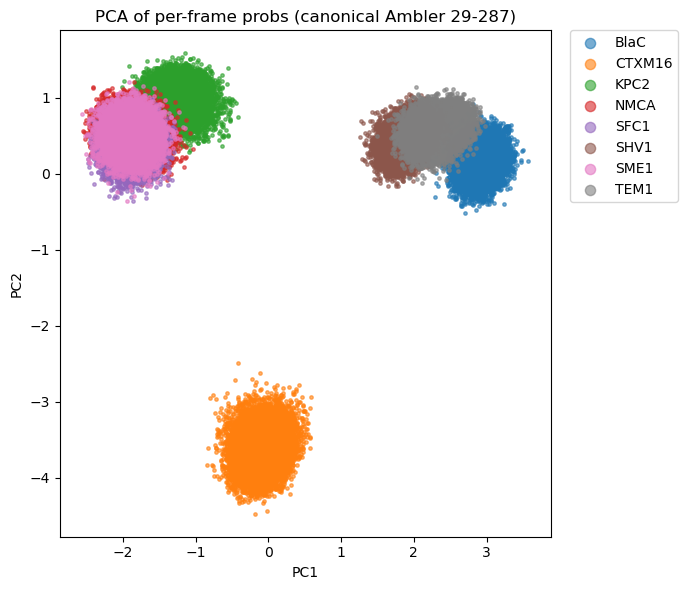

In [3]:

N_COMPONENTS = 2
BATCH_SIZE   = 512
AMBLER_START = 29
AMBLER_END   = 287

data_path = r"C:\Users\User\OneDrive - University of Bristol\Data Sci MSc\Summer Project\organised_data_new.h5"

def compute_master_ambler(h5_path, ambler_start, ambler_end):
    """Intersection of canonical Ambler bases present in all runs, sorted."""
    A_master = None
    with h5py.File(h5_path, "r") as f:
        for enzyme in f.keys():
            for run in f[enzyme].keys():
                amb = f[enzyme][run]["ambler_idx"][:]
                ins = f[enzyme][run]["ambler_ins_rank"][:]
                keep = (amb >= ambler_start) & (amb <= ambler_end) & (ins == 0)
                bases = np.unique(amb[keep].astype(int))
                if A_master is None:
                    A_master = bases
                else:
                    A_master = np.intersect1d(A_master, bases, assume_unique=False)
    return np.sort(A_master)

# precompute fixed columns for all batches
A_MASTER = compute_master_ambler(data_path, AMBLER_START, AMBLER_END)

def frame_batches_ambler(h5_path, batch_size, A_master):
    """
    Gives (X_batch, labels_batch) with fixed feature length: 20 * len(A_master).
    Columns are ordered exactly as in A_master.
    """
    with h5py.File(h5_path, "r") as f:
        for enzyme in f.keys():
            for run in f[enzyme].keys():
                ds   = f[enzyme][run]["probs"]            # (F,20,n_res)
                amb  = f[enzyme][run]["ambler_idx"][:]    # (n_res,)
                ins  = f[enzyme][run]["ambler_ins_rank"][:]
                # canonical in window
                keep = (ins == 0) & (amb >= AMBLER_START) & (amb <= AMBLER_END)
                if not np.any(keep):
                    continue

                amb_keep = amb[keep].astype(int)
                # map base -> col index in this run
                col_of_base = {}
                for j, base in zip(np.where(keep)[0], amb_keep):
                    # first occurrence = canonical column for that base
                    if base not in col_of_base:
                        col_of_base[base] = int(j)

                # build column indices in the exact order of A_master
                col_idx = np.array([col_of_base[b] for b in A_master], dtype=int)

                F = ds.shape[0]
                for start in range(0, F, batch_size):
                    stop  = min(start + batch_size, F)
                    chunk = np.asarray(ds[start:stop, :, col_idx], dtype=np.float32)  # (B,20,L)
                    Xb    = chunk.reshape(chunk.shape[0], -1)                         # (B,20*L)
                    labels = [{"enzyme": enzyme, "run": run, "frame_idx": i}
                              for i in range(start, stop)]
                    yield Xb, labels

# fit IPCA
ipca = IncrementalPCA(n_components=N_COMPONENTS, batch_size=BATCH_SIZE)
for Xb, _ in frame_batches_ambler(data_path, BATCH_SIZE, A_MASTER):
    ipca.partial_fit(Xb)

# transform + collect labels
pcs_list, labels_all = [], []
for Xb, labels in frame_batches_ambler(data_path, BATCH_SIZE, A_MASTER):
    pcs_list.append(ipca.transform(Xb))
    labels_all.extend(labels)

pcs = np.vstack(pcs_list)
labels_df = pd.DataFrame(labels_all)
emb_df = pd.concat([labels_df, pd.DataFrame(pcs, columns=[f"PC{i+1}" for i in range(N_COMPONENTS)])], axis=1)

# Quick scatter plot
plt.figure(figsize=(7,6))
for name, grp in emb_df.groupby("enzyme"):
    plt.scatter(grp["PC1"], grp["PC2"], s=6, alpha=0.6, label=name)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title(f"PCA of per-frame probs (canonical Ambler {AMBLER_START}-{AMBLER_END})")
plt.legend(markerscale=3, bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=0)
plt.tight_layout(); plt.show()


In [ ]:
# Analyse PCA loadings
AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")
L = len(A_MASTER)

def pca_loadings_df(ipca, A_MASTER, AA_LIST):
    rows = []
    for k, comp in enumerate(ipca.components_):              # shape: (20*L,)
        grid = comp.reshape(20, L)                            # (AA, Ambler)
        for aa_idx, aa in enumerate(AA_LIST):
            for j, amb in enumerate(A_MASTER):
                w = float(grid[aa_idx, j])
                rows.append({"PC": k+1, "AA": aa, "Ambler": int(amb),
                             "weight": w, "abs_weight": abs(w)})
    df = pd.DataFrame(rows)
    df["sign"] = np.sign(df["weight"]).astype(int)
    return df

loadings = pca_loadings_df(ipca, A_MASTER, AA_LIST)

# Top positive and negative contributors for each PC
for pc in range(1, ipca.n_components_ + 1):
    print(f"\n=== PC{pc} top +loadings ===")
    display(loadings[loadings["PC"]==pc].sort_values("weight", ascending=False).head(15))
    print(f"=== PC{pc} top -loadings ===")
    display(loadings[loadings["PC"]==pc].sort_values("weight", ascending=True).head(15))



=== PC1 top +loadings ===


,PC,AA,Ambler,weight,abs_weight,sign
1464,1,G,238,0.183706,0.183706,1
1450,1,G,224,0.102266,0.102266,1
1476,1,G,250,0.102034,0.102034,1
1857,1,I,127,0.100779,0.100779,1
3043,1,P,48,0.094910,0.094910,1
571,1,D,101,0.093991,0.093991,1
1493,1,G,267,0.087685,0.087685,1
4805,1,Y,46,0.087305,0.087305,1
2441,1,L,207,0.085799,0.085799,1
1491,1,G,265,0.079139,0.079139,1


=== PC1 top -loadings ===


,PC,AA,Ambler,weight,abs_weight,sign
1273,1,G,42,-0.167595,0.167595,-1
1373,1,G,147,-0.166778,0.166778,-1
1458,1,G,232,-0.162784,0.162784,-1
3246,1,P,256,-0.159595,0.159595,-1
190,1,A,224,-0.141727,0.141727,-1
19,1,A,48,-0.122707,0.122707,-1
1283,1,G,52,-0.109718,0.109718,-1
2012,1,I,283,-0.106955,0.106955,-1
4511,1,V,261,-0.105309,0.105309,-1
456,1,C,238,-0.100137,0.100137,-1



=== PC2 top +loadings ===


,PC,AA,Ambler,weight,abs_weight,sign
6382,2,G,116,0.211473,0.211473,1
6325,2,G,54,0.149120,0.149120,1
8892,2,S,106,0.146642,0.146642,1
5230,2,A,224,0.121031,0.121031,1
6510,2,G,244,0.115305,0.115305,1
7413,2,L,139,0.101999,0.101999,1
7352,2,L,76,0.101792,0.101792,1
7910,2,N,132,0.085341,0.085341,1
6323,2,G,52,0.084276,0.084276,1
9096,2,T,53,0.075085,0.075085,1


=== PC2 top -loadings ===


,PC,AA,Ambler,weight,abs_weight,sign
6490,2,G,224,-0.167286,0.167286,-1
7312,2,L,33,-0.140014,0.140014,-1
6330,2,G,62,-0.137182,0.137182,-1
6504,2,G,238,-0.132989,0.132989,-1
6505,2,G,239,-0.122358,0.122358,-1
6381,2,G,115,-0.116238,0.116238,-1
7914,2,N,136,-0.113061,0.113061,-1
6324,2,G,53,-0.112597,0.112597,-1
7884,2,N,106,-0.112154,0.112154,-1
7550,2,L,277,-0.111450,0.111450,-1


In [6]:
site_imp = []
for k, comp in enumerate(ipca.components_, start=1):
    grid = comp.reshape(20, len(A_MASTER))
    imp = np.abs(grid).sum(axis=0)   # sum over AAs
    site_imp.append(pd.DataFrame({"PC": k, "Ambler": A_MASTER, "importance": imp}))

site_imp_df = pd.concat(site_imp, ignore_index=True)
display(site_imp_df.sort_values(["PC", "importance"], ascending=[True, False]).groupby("PC").head(15))


,PC,Ambler,importance
204,1,238,0.368205
19,1,48,0.344040
18,1,47,0.343163
13,1,42,0.335105
113,1,147,0.333486
222,1,256,0.333221
27,1,56,0.332509
198,1,232,0.325419
238,1,273,0.319236
190,1,224,0.311342


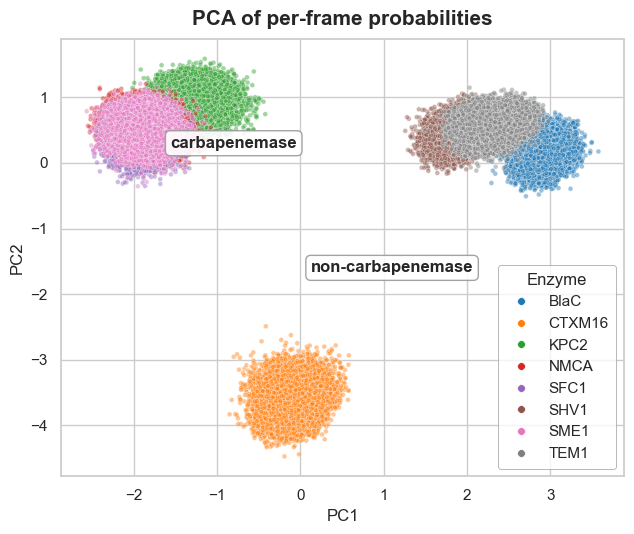

In [ ]:

df = emb_df.copy()  
carba_enzymes = {"NMCA", "SFC1", "KPC2", "SME1"}
df["class_label"] = np.where(
    df["enzyme"].str.upper().isin({e.upper() for e in carba_enzymes}),
    "carbapenemase",
    "non-carbapenemase"
)

# Set manual label positions
class_label_positions = {
    "carbapenemase": (-0.8, 0.3),   
    "non-carbapenemase": (1.1, -1.6)
}

sns.set_theme(style="whitegrid")
sns.set_palette("tab10")

fig, ax = plt.subplots(figsize=(6.5,5.5))
sns.scatterplot(
    data=df, x="PC1", y="PC2",
    hue="enzyme",
    s=12, alpha=0.45, linewidth=0.4, edgecolor="w", ax=ax
)

ax.set_title("PCA of per-frame probabilities", fontsize=15, pad=10, weight="bold")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

# add labels 
for cls, g in df.groupby("class_label"):
    xy = class_label_positions[cls]

    ax.annotate(
        cls, xy=xy, xytext=(0,0), textcoords="offset points",
        ha="center", va="center",
        fontsize=12, weight="bold",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.6", alpha=0.9)
    )

# enzyme legend
handles, labels = ax.get_legend_handles_labels()
enzymes = list(df["enzyme"].astype(str).unique())
pairs = [(h,l) for h,l in zip(handles, labels) if l in enzymes]
for h,_ in pairs:
    if hasattr(h,"set_alpha"): h.set_alpha(1.0)
    if hasattr(h,"set_sizes"): h.set_sizes([60])

leg = ax.legend(
    *zip(*pairs), title="Enzyme",
    loc="lower right", frameon=True,
    scatterpoints=1, borderpad=0.5, markerscale=1.6
)
leg.get_frame().set_edgecolor("0.6"); leg.get_frame().set_linewidth(0.6)

plt.tight_layout()
plt.show()


------------------

In [1]:
import h5py
import numpy as np
import pandas as pd

DATA_PATH = r"C:\Users\User\OneDrive - University of Bristol\Data Sci MSc\Summer Project\organised_data.h5"
AA_ORDER = "ACDEFGHIKLMNPQRSTVWY"
AA2IDX = {aa: i for i, aa in enumerate(AA_ORDER)}

def per_aa_stats(h5_path, batch=1000):
    total   = np.zeros(20, dtype=np.int64)  # opportunities per native AA (over all frames)
    correct = np.zeros(20, dtype=np.int64)  # correct predictions per native AA
    picked  = np.zeros(20, dtype=np.int64)  # argmax picks across all frames/residues
    should  = np.zeros(20, dtype=np.int64)  # same as total but computed per-batch

    with h5py.File(h5_path, "r") as f:
        for enzyme in f.keys():
            # native sequence indices (assumes run residue order == sequence order)
            seq_chars = list(f[enzyme].attrs["sequence"])
            seq_idx_full = np.array([AA2IDX[a] for a in seq_chars], dtype=np.int64)

            for run in f[enzyme].keys():
                ds = f[enzyme][run]["probs"]   # shape (F, 20, L)
                F, _, L = ds.shape
                native_idx = seq_idx_full[:L]  # (L,)

                for s in range(0, F, batch):
                    e = min(s + batch, F)
                    probs = ds[s:e]                # (b, 20, L)
                    b = probs.shape[0]

                    winners = probs.argmax(axis=1) # (b, L)

                    # counts for how often each native AA appears in this slice
                    should += np.bincount(native_idx, minlength=20) * b
                    total  += np.bincount(native_idx, minlength=20) * b

                    # how many times each residue was predicted correctly in this slice
                    correct_per_res = (winners == native_idx[None, :]).sum(axis=0)  # (L,)
                    correct += np.bincount(native_idx, weights=correct_per_res, minlength=20).astype(np.int64)

                    # how often each AA was picked by argmax overall
                    picked += np.bincount(winners.ravel(), minlength=20)

    df = pd.DataFrame({
        "AA": list(AA_ORDER),
        "total": total,
        "correct": correct,
        "picked": picked,
        "should": should
    })
    df["prop_correct"] = np.divide(df["correct"], df["total"], out=np.full(20, np.nan), where=(df["total"] > 0))
    df["picked_over_should"] = np.divide(df["picked"], df["should"], out=np.full(20, np.nan), where=(df["should"] > 0))
    return df


df = per_aa_stats(DATA_PATH, batch=1000)
print(df[["AA", "prop_correct", "picked_over_should"]].sort_values("prop_correct", ascending=False))


   AA  prop_correct  picked_over_should
12  P      0.788317            1.510118
5   G      0.758846            1.112371
9   L      0.678083            1.262376
19  Y      0.485499            1.388192
17  V      0.473333            1.016458
0   A      0.463918            0.945530
7   I      0.441901            0.944152
4   F      0.426646            1.231253
2   D      0.386127            0.906430
3   E      0.356906            1.768763
8   K      0.344855            1.207899
16  T      0.336122            0.737460
18  W      0.326956            0.867294
1   C      0.276054            0.879767
15  S      0.257221            0.839057
14  R      0.246932            0.703063
11  N      0.236037            0.805118
13  Q      0.088114            0.265986
6   H      0.083690            0.617487
10  M      0.065184            0.200433
